In [1]:
import numpy as np
import pandas as pd
import joblib
import sys, os
sys.path.insert(0, '/home/monte.flora/python_packages/WoF_post')
sys.path.insert(0, '/home/monte.flora/python_packages/ml_workflow')
sys.path.insert(0, '/home/monte.flora/python_packages/wofs_ml_severe')

from wofs_ml_severe.io.load_ml_models import load_ml_model
from wofs.post.utils import load_yaml
import skexplain 
from skexplain.common.importance_utils import to_skexplain_importance 
from display_names import to_display_name, to_units, to_color, map_to_readable_names

lookup_file: /home/monte.flora/python_packages/WoF_post/wofs/data/psadilookup.dat


In [2]:
time = 'first_hour'
target = 'wind_severe_0km'
retro=False 

ml_config = load_yaml(
    '/home/monte.flora/python_packages/wofs_ml_severe/wofs_ml_severe/conf/ml_config_retro.yml')

parameters = {
                'target' : target,
                'time' : time, 
                'drop_opt' : '',
                'model_name' : 'LogisticRegression',
                'ml_config' : ml_config,
            }

model_dict = load_ml_model(retro, **parameters)
model = model_dict['model']
features = model_dict['X'].columns

In [3]:
base_est = model.calibrated_classifiers_[0].base_estimator

# Get the model coefficients. 
coef = base_est.named_steps['model'].coef_[0, :]

coef_rank = to_skexplain_importance(coef, estimator_name='LR', feature_names=features, 
                                   method = 'coefs'
                                   )

In [4]:
coef_rank['coefs_rankings__LR'].values[:8]

array(['div_10m__time_min__ens_std__spatial_mean',
       'lcl_ml__ens_mean__spatial_mean',
       'ws_80__time_max__amp_ens_mean_spatial_perc_90',
       'shear_u_0to6__ens_mean__spatial_mean',
       'shear_v_0to6__ens_mean__spatial_mean',
       'td_500__ens_mean__spatial_mean',
       'w_1km__time_max__ens_std__spatial_mean',
       'qv_2__ens_mean__spatial_mean'], dtype=object)

In [5]:
display_feature_names = {f : to_display_name(f) for f in coef_rank['coefs_rankings__LR'].values}
feature_colors = {f : to_color(f) for f in coef_rank['coefs_rankings__LR'].values}

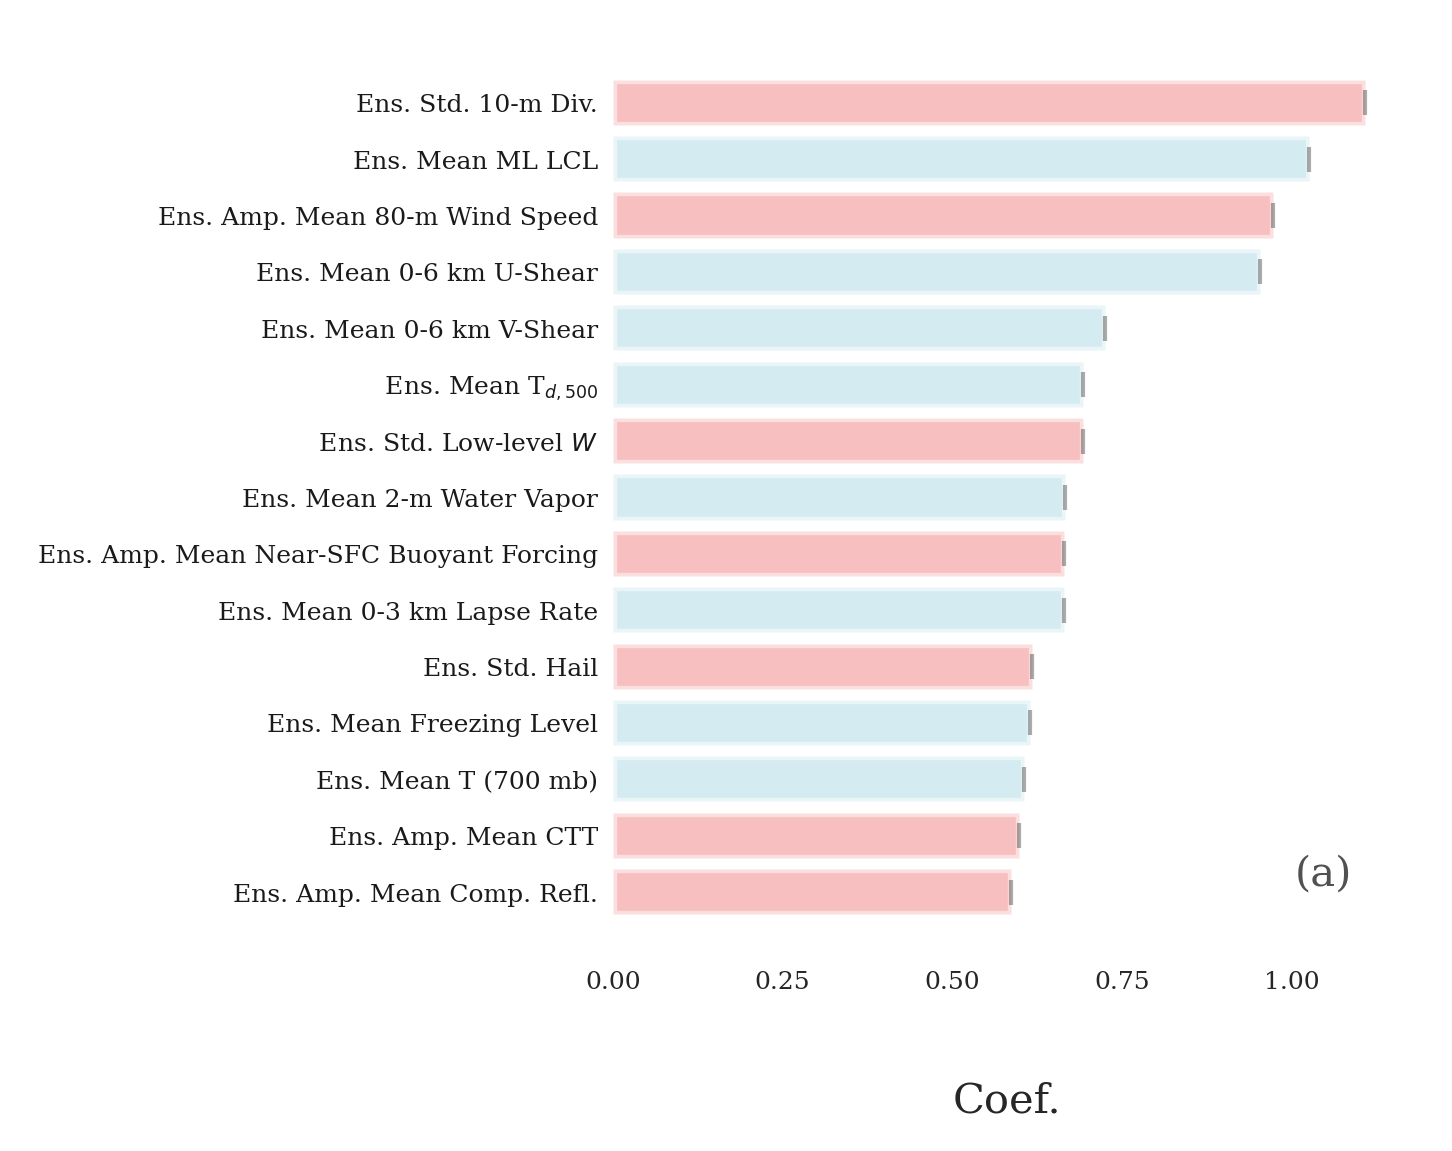

In [6]:
%matplotlib inline
data = [coef_rank]
panels = [('coefs', 'LR'), 
          ]

explainer = skexplain.ExplainToolkit()
fig = explainer.plot_importance(data=data, 
                                panels=panels, 
                                num_vars_to_plot=15, 
                                figsize=(5,4), 
                                display_feature_names = display_feature_names,
                                feature_colors = feature_colors, 
                               )

In [7]:
base_names = np.unique([f.split('__')[0] for f in features])

coefs_summed = np.zeros(len(base_names))
for i, name in enumerate(base_names):
    coefs_summed[i] = np.sum([abs(c) for f,c in zip(features, coef) if name in f])
 
coef_rank_sum = to_skexplain_importance(coefs_summed, 
                                        estimator_name='LR', 
                                        feature_names=base_names, 
                                        method = 'coefs'
                                   )

In [8]:
coef_rank_sum['coefs_rankings__LR'].values[:8]

array(['v_10', 'div_10m', 'comp_dz', '10-500m_bulkshear', 'w_1km',
       'ws_80', 'lcl_ml', 'ctt'], dtype='<U22')

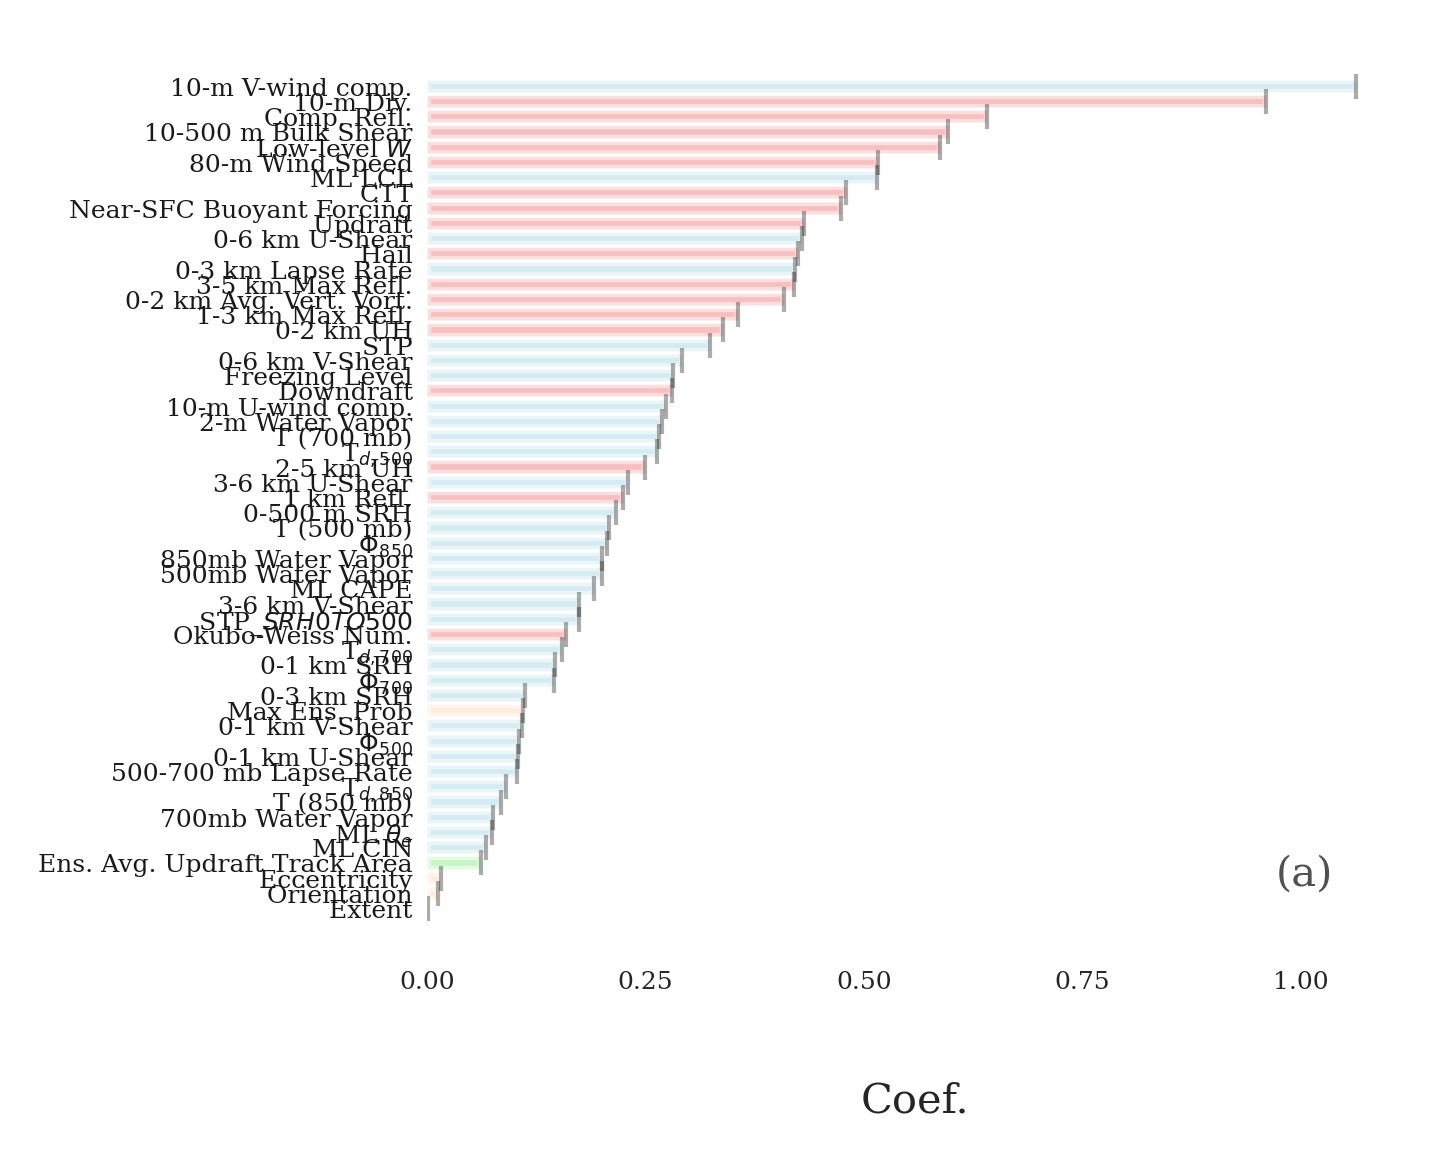

In [9]:
%matplotlib inline
data = [coef_rank_sum]
panels = [('coefs', 'LR'), 
          ]


display_feature_names = {f.split('__')[0] : map_to_readable_names[f.split('__')[0]] 
                         for f in features}
feature_colors = {f.split('__')[0] : to_color(f) for f in features}


explainer = skexplain.ExplainToolkit()
fig = explainer.plot_importance(data=data, 
                                panels=panels, 
                                num_vars_to_plot=100, 
                                figsize=(5,4), 
                                display_feature_names = display_feature_names,
                                feature_colors = feature_colors, 
                               )

In [10]:
scores = coef_rank_sum['coefs_scores__LR'].values[:,0]

drop_vars = list(coef_rank_sum['coefs_rankings__LR'].values[scores<0.25])

In [11]:
drop_vars

['uh_2to5_instant',
 'shear_u_3to6',
 'dbz_1km',
 'srh_0to500',
 'temperature_500',
 'geo_hgt_850',
 'QVAPOR_850',
 'QVAPOR_500',
 'cape_ml',
 'shear_v_3to6',
 'stp_srh0to500',
 'okubo_weiss',
 'td_700',
 'srh_0to1',
 'geo_hgt_700',
 'srh_0to3',
 'ens_track_prob',
 'shear_v_0to1',
 'geo_hgt_500',
 'shear_u_0to1',
 'mid_level_lapse_rate',
 'td_850',
 'temperature_850',
 'QVAPOR_700',
 'theta_e',
 'cin_ml',
 'avg_updraft_track_area',
 'eccentricity',
 'orientation',
 'extent']

In [12]:
X = model_dict['X']

In [13]:
removed_features = []
for f in X.columns:
    if any([v in f for v in drop_vars]):
        removed_features.append(f)
        

In [14]:
removed_features

['theta_e__ens_mean__spatial_mean',
 'temperature_850__ens_mean__spatial_mean',
 'temperature_500__ens_mean__spatial_mean',
 'td_850__ens_mean__spatial_mean',
 'td_700__ens_mean__spatial_mean',
 'mid_level_lapse_rate__ens_mean__spatial_mean',
 'geo_hgt_850__ens_mean__spatial_mean',
 'geo_hgt_500__ens_mean__spatial_mean',
 'geo_hgt_700__ens_mean__spatial_mean',
 'QVAPOR_850__ens_mean__spatial_mean',
 'QVAPOR_700__ens_mean__spatial_mean',
 'QVAPOR_500__ens_mean__spatial_mean',
 'srh_0to1__ens_mean__spatial_mean',
 'srh_0to3__ens_mean__spatial_mean',
 'srh_0to500__ens_mean__spatial_mean',
 'cape_ml__ens_mean__spatial_mean',
 'cin_ml__ens_mean__spatial_mean',
 'shear_u_0to1__ens_mean__spatial_mean',
 'shear_v_0to1__ens_mean__spatial_mean',
 'shear_u_3to6__ens_mean__spatial_mean',
 'shear_v_3to6__ens_mean__spatial_mean',
 'stp_srh0to500__ens_mean__spatial_mean',
 'uh_2to5_instant__time_max__ens_mean__spatial_mean',
 'dbz_1km__time_max__ens_mean__spatial_mean',
 'okubo_weiss__time_min__ens_m